## Libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Mounted at /gdrive
/gdrive/My Drive


In [ ]:
import os
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

import cmdstanpy
cmdstanpy.install_cmdstan()

cmdstan_path()

Installing CmdStan version: 2.31.0
Install directory: /root/.cmdstan
Download successful, file: /tmp/tmpndb763_c
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.31.0
Building version cmdstan-2.31.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Test model compilation
Installed cmdstan-2.31.0


'/root/.cmdstan/cmdstan-2.31.0'

## Data preprocessing

In [ ]:
import pandas as pd
data = pd.read_csv("viagggi_individui_2014_2021.txt")

In [ ]:
# select years 2019 and 2021

mask = data.annrif != 2014
mask2 = data.annrif != 2015
mask3 = data.annrif != 2016
mask4 = data.annrif != 2018
mask5 = data.annrif != 2020
res = mask * mask2 * mask3 * mask4 * mask5 
data1 = data[res].drop("Unnamed: 0",axis = 1).fillna(-1)
data = data1

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
data_2 = data[data.annrif == 2019]
m = data_2.DURATA > 0
data_2_trav = data_2[m]
print(data_2_trav.shape)
data_2_notrav = data_2[~m]
print(data_2_notrav.shape)
data_2_trav = data_2_trav.sample(n=1300, random_state=1)
data_2_notrav = data_2_notrav.sample(n=1300, random_state=1)
print(data_2_trav.shape)
print(data_2_notrav.shape)

data_3 = data[data.annrif == 2021]
m = data_3.DURATA > 0
data_3_trav = data_3[m]
print(data_3_trav.shape)
data_3_notrav = data_3[~m]
print(data_3_notrav.shape)
data_3_trav = data_3_trav.sample(n=1300, random_state=1)
data_3_notrav = data_3_notrav.sample(n=1300, random_state=1)
print(data_3_trav.shape)
print(data_3_notrav.shape)

data_ = pd.concat([data_2_trav,data_2_notrav,data_3_trav,data_3_notrav])
data = data_

(4393, 25)
(38801, 25)
(1300, 25)
(1300, 25)
(4284, 25)
(60602, 25)
(1300, 25)
(1300, 25)


In [ ]:
years = pd.DataFrame()

In [ ]:
years["year"] = data["annrif"]

In [ ]:
df = pd.DataFrame()

Select covariates:


*   civil state
*   region of origin
*   education level
*   type of travel

and perform one-hot encoding (baseline: unmarried, north-west, elementary school, work travel)

In [ ]:
# civil state
name = "staciv4"
cols = ["married","divorced","widowed"]

enc = OneHotEncoder()
or_val = data[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df[cols] = df_temp

In [ ]:
# region of origin
name = "rip"
cols = ["North-East","Center","South","Islands"]

enc = OneHotEncoder()
or_val = data[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df[cols] = df_temp

In [ ]:
# education level
name = "istr4"
cols = ["middle school","high school","university"]

enc = OneHotEncoder()
or_val = data[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df[cols] = df_temp

In [ ]:
# type of travel
name = "TIPOVGG"
cols = ["vacation trip"]

enc = OneHotEncoder()
or_val = data[name].astype(str)
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
df_temp = pd.DataFrame(t_val)
df_temp = df_temp.loc[:,2:]
df_temp.columns = cols

df[cols] = df_temp

In [ ]:
print(df.shape)

(5200, 11)


## STAN

In [ ]:
# STAN model

model_stan_full = """

    functions {

      // custom multiple inflated truncated negative binomial log probability mass function
      real f2_lpmf(int y, real prob_inflated, real prob_baseline, real lambda, real theta, vector inflated_values, int n_inflated) {
        return log(prob_inflated + prob_baseline*(exp(lchoose(y+lambda-1,y)) * pow(theta/(1+theta),y) * pow(1/(1+theta),lambda))/(1-pow(1/(1+theta),lambda)));

     }

    }

    data {

      // number of samples
      int<lower=0> n_samples_trav;
      // number of covariates
      int<lower=0> p2;
      // inflated values
      int<lower=0> n_inflated;
      vector[n_inflated] inflated_values;
      // data
      int<lower=1> y_trav[n_samples_trav];
      matrix[n_samples_trav,p2] Z;
      // matrix for computation of p_ij mixing probabilities
      vector[n_inflated] inflated_check[n_samples_trav];

    }

    parameters {

      // parameters for lambda = location parameter (non-centered parametrization)
      vector[p2] beta_lambda_raw;
      // parameters for theta = dispersion parameter (non-centered parametrization)
      vector[p2] beta_theta_raw;
      // parameters for p_ij = mixing probabilites 
      matrix[n_inflated,p2] beta_inflated;
      
    }
    
    transformed parameters {

      // true beta_lambda
      vector[p2] beta_lambda;
      beta_lambda = 10.0 * beta_lambda_raw;
      // lambda computation
      vector<lower=1>[n_samples_trav] lambda;
      lambda = 1 + exp(Z * beta_lambda);

      // true beta_theta
      vector[p2] beta_theta;
      beta_theta = 10.0 * beta_theta_raw;
      // theta computation
      vector<lower = 0>[n_samples_trav] theta;
      theta = exp(Z * beta_theta);

      // p_ij computation
      vector<lower=0,upper=1>[n_inflated+1] prob_inflated[n_samples_trav];
      matrix[n_samples_trav,n_inflated] tmp;
      tmp = exp(Z*beta_inflated');
      real den = 0;
      for(i in 1:n_samples_trav) {
        den = sum(tmp[i]);
        for(j in 1:n_inflated) {
          prob_inflated[i][j] = tmp[i][j]/(1+den);
        }       
        prob_inflated[i][n_inflated+1] = 1/(1+den);
      }   


    }


    model {
      
      for (i in 1:n_samples_trav) {
        target += f2_lpmf(y_trav[i]|inflated_check[i]'*prob_inflated[i,1:n_inflated],prob_inflated[i,n_inflated+1],lambda[i],theta[i],inflated_values,n_inflated);
      }
      
      // priors: 
      beta_lambda_raw ~ std_normal();
      beta_theta_raw ~ std_normal();
      for (j in 1:n_inflated) {
        beta_inflated[j] ~ double_exponential(0.0, 2.0);
      }

    }

    generated quantities  {

      // log likelihood for model comparison      
      vector[n_samples_trav] log_lik;
      for (i in 1:n_samples_trav) {
        log_lik[i] = f2_lpmf(y_trav[i]|inflated_check[i]'*prob_inflated[i,1:n_inflated],prob_inflated[i,n_inflated+1],lambda[i],theta[i],inflated_values,n_inflated);
      }

    }

"""

In [ ]:
stan_file = "./full_test.stan"

with open(stan_file, "w") as f:
    print(model_stan_full, file=f)

stan_model = CmdStanModel(stan_file=stan_file)

In [ ]:
# "auto-format" flag to fix deprecated delcarations

stan_model.format(
    overwrite_file = True,
    canonicalize = True,
    # max_line_length = 78,
    backup = False
)

In [ ]:
# STAN data preparation

data.loc[data["DURATA"] == -1,"DURATA"] = 0
Y = np.array(data["DURATA"],dtype = int)
Z = df
Z = np.column_stack([np.ones_like(Y), Z])
print(Y.shape)
print(Z.shape)
print(sum(np.isnan(Z)))

In [ ]:
y_trav = np.array(Y[Y>=1])
z_trav = Z[Y>=1,:] 
print(len(y_trav))
print(z_trav.shape)

In [ ]:
import collections
counter = collections.Counter(y_trav)
print(counter)

In [ ]:
n_inflated = 7
inflated_values = [2,7,10,14,15,20,30]

In [ ]:
inflated_check = np.zeros((len(y_trav),n_inflated))
for i in range(len(y_trav)):
  for j,val in enumerate(inflated_values):
    if (y_trav[i] == val):
      inflated_check[i,j] = 1

In [ ]:
stan_data = {
    "n_samples_trav": len(y_trav),
    "y_trav": y_trav,
    "Z": z_trav,
    "p2": z_trav.shape[1],
    "n_inflated": n_inflated,
    "inflated_values": inflated_values,
    "inflated_check": inflated_check
}

In [ ]:
# STAN computations

stan_test_fit = stan_model.sample(data=stan_data, chains=1, parallel_chains=1, 
                             iter_warmup=4000, iter_sampling=3000,
                             adapt_delta=0.9,
                             inits  = 0,
                             show_console=True)

In [ ]:
cmdstanpy_data = az.from_cmdstanpy(stan_test_fit)
az.plot_trace(cmdstanpy_data,var_names=["beta_lambda"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
az.plot_trace(cmdstanpy_data,var_names=["beta_theta"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
az.plot_trace(cmdstanpy_data,var_names=["beta_inflated"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
az.to_netcdf(data = cmdstanpy_data, filename = '2y_25c_inf1_bis.dat')

## Inflated Values Comparison

We compare which choice of inflated values provide the better fit using predicting information criteria, such as WAIC and LOO-CV.

In [ ]:
inf1 = az.from_netcdf(filename = '2y_12c_long_inf1_lik.dat')
inf2 = az.from_netcdf(filename = '2y_12c_long_inf2_lik.dat')
inf3 = az.from_netcdf(filename = '2y_12c_long_inf3_lik.dat')
inf4 = az.from_netcdf(filename = '2y_12c_long_inf4_lik.dat')

In [ ]:
# WAIC

print("inf1: ", az.waic(inf1,var_name="log_lik"))
print("inf2: ", az.waic(inf2,var_name="log_lik"))
print("inf3: ", az.waic(inf3,var_name="log_lik"))
print("inf4: ", az.waic(inf4,var_name="log_lik"))

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


inf1:  Computed from 2000 posterior samples and 2600 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6790.65    55.60
p_waic      102.37        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


inf2:  Computed from 2000 posterior samples and 2600 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6770.01    54.91
p_waic       94.93        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


inf3:  Computed from 2000 posterior samples and 2600 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6770.27    54.94
p_waic       95.02        -

There has been a warning during the calculation. Please check the results.
inf4:  Computed from 2000 posterior samples and 2600 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6765.69    54.25
p_waic       97.35        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [ ]:
# LOO-CV

print("inf1: ", az.loo(inf1,var_name="log_lik"))
print("inf2: ", az.loo(inf2,var_name="log_lik"))
print("inf3: ", az.loo(inf3,var_name="log_lik"))
print("inf4: ", az.loo(inf4,var_name="log_lik"))

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


inf1:  Computed from 2000 posterior samples and 2600 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6790.70    55.64
p_loo      102.42        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2588   99.5%
 (0.5, 0.7]   (ok)          9    0.3%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    2    0.1%



/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


inf2:  Computed from 2000 posterior samples and 2600 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6770.42    54.96
p_loo       95.34        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2577   99.1%
 (0.5, 0.7]   (ok)         14    0.5%
   (0.7, 1]   (bad)         8    0.3%
   (1, Inf)   (very bad)    1    0.0%



/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


inf3:  Computed from 2000 posterior samples and 2600 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6770.68    54.99
p_loo       95.43        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2585   99.4%
 (0.5, 0.7]   (ok)         10    0.4%
   (0.7, 1]   (bad)         4    0.2%
   (1, Inf)   (very bad)    1    0.0%



/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


inf4:  Computed from 2000 posterior samples and 2600 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6766.71    54.36
p_loo       98.36        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2574   99.0%
 (0.5, 0.7]   (ok)         20    0.8%
   (0.7, 1]   (bad)         5    0.2%
   (1, Inf)   (very bad)    1    0.0%



In [ ]:
# total LOO_CV comparisons

az.compare({"inf1": inf1, "inf2": inf2, "inf3": inf3, "inf4": inf4 })

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:812: UserWarning: Estimated sh

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
inf4,0,-6766.706931,98.363371,0.000000,7.975671e-01,54.359155,0.000000,True,log
inf2,1,-6770.419899,95.337517,3.712968,1.510099e-17,54.955246,5.093815,True,log
inf3,2,-6770.676002,95.431912,3.969070,0.000000e+00,54.990920,5.135155,True,log
inf1,3,-6790.698446,102.415078,23.991514,2.024329e-01,55.639857,10.283380,True,log


In [ ]:
# total WAIC comparisons

az.compare({"inf1": inf1, "inf2": inf2, "inf3": inf3, "inf4": inf4 }, ic = "waic")

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
inf4,0,-6765.694821,97.351260,0.000000,8.086046e-01,54.248238,0.000000,True,log
inf2,1,-6770.014857,94.932474,4.320036,2.000217e-17,54.914156,5.658712,True,log
inf3,2,-6770.265882,95.021793,4.571062,3.983191e-18,54.942437,5.697357,True,log
inf1,3,-6790.652636,102.369268,24.957815,1.913954e-01,55.603813,10.507176,True,log


Having some "very bad" results in the chains, we can't really trust the LOO-CV results, which however reflect what we can see from the WAIC analysis. According to WAIC, inf1 is worse than all other choices, while inf2, inf3 and inf4 perform almost the same (difference of WAIC < 10). We therefore choose to work with inf2. We do this for 2 main reasons: first of all, we prefer to work with the simplest model among the ones peroforming the same, since the computational weight is already considerable. The second reason is that there is the possibility that inf3 and inf4 are slightly better than inf2 only due to the capability of taking care of outlying data specific to our case (73,110), therefore by not considering them we might achieve more generality. We can see that the resulting inflated values might make sense, being multiples of tipical amount of days one might want to go to vacation on, such as weekends (2 days) and multiples of a week (7 days) or 10 days.

In [ ]:
inf = inf2
n_inflated = 7
inflated_values = [2,7,10,14,15,20,30]

## Covariates Selection (Hard Shrinkage 95%)

Working with suitable absolutely continuous priors, we resort to sparse regression. We use Hard Shrinkage to see which covariates are actually relevant, i.e. we see which variables' 95% credibility intervals do not contain 0.

(baseline: unmarried, north-west, elementary school, work trip)


In [ ]:
stacked = az.hdi(inf, hdi_prob = 0.95)

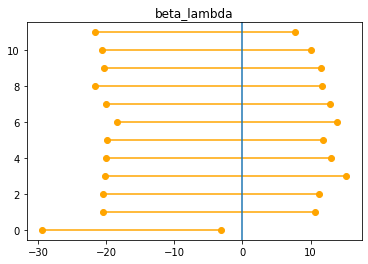

In [ ]:
# lambda
stacked_np = stacked['beta_lambda'].to_numpy()
num_beta = range(stacked_np.shape[0])
for interval, y in zip(stacked_np,num_beta):
  plt.plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
plt.axvline(0)
plt.title("beta_lambda");

Quite surprisingly, no covariates seem relevant regarding the location parameter lambda. The only relevant effect is negative and given by the baseline. Considering the transformation that we work with (lambda = 1+exp(...)), this suggests us that lambda shoudl be approximately 1 for all the individuals in our study (posterior mean of lambda: 1.006)

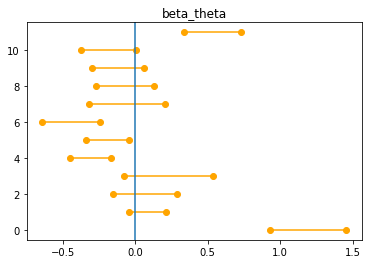

In [ ]:
# theta
stacked_np = stacked['beta_theta'].to_numpy()
num_beta = range(stacked_np.shape[0])
for interval, y in zip(stacked_np,num_beta):
  plt.plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
plt.axvline(0)
plt.title("beta_theta");

As for the scale parameter, the situation is more variegated. The relevant covariates are 4: north-east, center and south with a negative effect, vacation trip with a positive effect. Coming from the north-eastern, central or southern part of Italy leeds to a greater range of possible days spent in vacation (greater dispersion), while going on a vacation trip decreases such range.

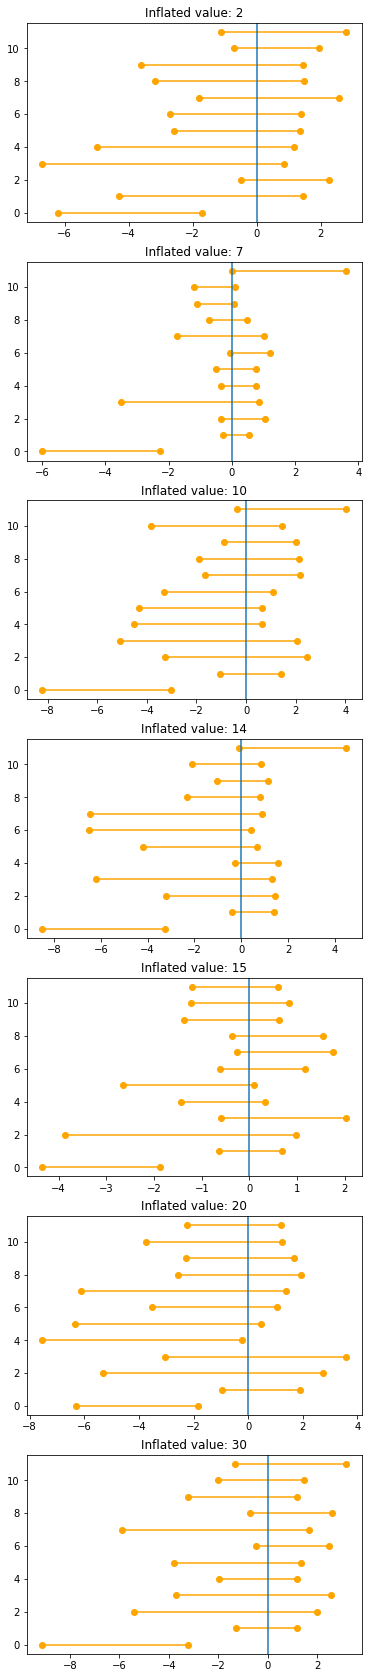

In [ ]:
# inflated values
stacked_np = stacked['beta_inflated'].to_numpy()
fig, axes = plt.subplots(stacked_np.shape[0],1, figsize=(6, 30))
for i,j in enumerate(stacked_np):
  num_beta = range(j.shape[0])
  for interval, y in zip(j,num_beta):
    axes[i].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
  axes[i].axvline(0)
  axes[i].set_title("Inflated value: {}".format(inflated_values[i]))


The only relevant effects are linked with the covariates vacation trip for the inflated value 7 and north east for the inflated value 20.

## Time effect

In [ ]:
# STAN model

model_stan_full = """

    functions {

      real f2_lpmf(int y, real prob_inflated, real prob_baseline, real lambda, real theta, vector inflated_values, int n_inflated) {
        return log(prob_inflated + prob_baseline*(exp(lchoose(y+lambda-1,y)) * pow(theta/(1+theta),y) * pow(1/(1+theta),lambda))/(1-pow(1/(1+theta),lambda)));
     }

    }

    data {

      // number of samples
      int<lower=0> n_samples_trav;
      // number of covariates
      int<lower=0> p2;
      // inflated values
      int<lower=0> n_inflated;
      vector[n_inflated] inflated_values;
      // data
      int<lower=1> y_1[n_samples_trav];
      int<lower=1> y_2[n_samples_trav];
      matrix[n_samples_trav,p2] Z_1;
      matrix[n_samples_trav,p2] Z_2;
      // matrix for computation of p_ij
      vector[n_inflated] inflated_check_1[n_samples_trav];
      vector[n_inflated] inflated_check_2[n_samples_trav];

    }

    parameters {

      // params for lambda
      vector[p2] beta_lambda_raw_1;
      vector[p2] beta_lambda_raw_2;
      // params for theta
      vector[p2] beta_theta_raw_1;
      vector[p2] beta_theta_raw_2;
      // params for p_ij
      matrix[n_inflated,p2] beta_inflated_1;
      matrix[n_inflated,p2] beta_inflated_2;
      
    }
    
    transformed parameters {

      // true beta_lambda
      vector[p2] beta_lambda_1;
      beta_lambda_1 = 10.0 * beta_lambda_raw_1;
      vector[p2] beta_lambda_2;
      beta_lambda_2 = 10.0 * beta_lambda_raw_2;
      // lambda computation
      vector<lower=1>[n_samples_trav] lambda_1;
      lambda_1 = 1 + exp(Z_1 * beta_lambda_1);
      vector<lower=1>[n_samples_trav] lambda_2;
      lambda_2 = 1 + exp(Z_2 * beta_lambda_2);

      // true beta_theta
      vector[p2] beta_theta_1;
      beta_theta_1 = 10.0 * beta_theta_raw_1;
      vector[p2] beta_theta_2;
      beta_theta_2 = 10.0 * beta_theta_raw_2;
      // theta computation
      vector<lower = 0>[n_samples_trav] theta_1;
      theta_1 = exp(Z_1 * beta_theta_1);
      vector<lower = 0>[n_samples_trav] theta_2;
      theta_2 = exp(Z_2 * beta_theta_2);

      // p_ij computation
      vector<lower=0,upper=1>[n_inflated+1] prob_inflated_1[n_samples_trav];
      matrix[n_samples_trav,n_inflated] tmp_1;
      tmp_1 = exp(Z_1*beta_inflated_1');
      real den_1 = 0;
      for(i in 1:n_samples_trav) {
        den_1 = sum(tmp_1[i]);
        for(j in 1:n_inflated) {
          prob_inflated_1[i][j] = tmp_1[i][j]/(1+den_1);
        }       
        prob_inflated_1[i][n_inflated+1] = 1/(1+den_1);
      }  
      vector<lower=0,upper=1>[n_inflated+1] prob_inflated_2[n_samples_trav];
      matrix[n_samples_trav,n_inflated] tmp_2;
      tmp_2 = exp(Z_2*beta_inflated_2');
      real den_2 = 0;
      for(i in 1:n_samples_trav) {
        den_2 = sum(tmp_2[i]);
        for(j in 1:n_inflated) {
          prob_inflated_2[i][j] = tmp_2[i][j]/(1+den_2);
        }       
        prob_inflated_2[i][n_inflated+1] = 1/(1+den_2);
      }  


    }


    model {
      
      for (i in 1:n_samples_trav) {
        target += f2_lpmf(y_1[i]|inflated_check_1[i]'*prob_inflated_1[i,1:n_inflated],prob_inflated_1[i,n_inflated+1],lambda_1[i],theta_1[i],inflated_values,n_inflated);
        target += f2_lpmf(y_2[i]|inflated_check_2[i]'*prob_inflated_2[i,1:n_inflated],prob_inflated_2[i,n_inflated+1],lambda_2[i],theta_2[i],inflated_values,n_inflated);
      }
      
      // priors: 
      beta_lambda_raw_1 ~ std_normal();
      beta_lambda_raw_2 ~ std_normal();
      beta_theta_raw_1 ~ std_normal();
      beta_theta_raw_2 ~ std_normal();
      for (j in 1:n_inflated) {
        beta_inflated_1[j] ~ double_exponential(0.0, 2.0);
        beta_inflated_2[j] ~ double_exponential(0.0, 2.0);
      }

    }

"""

In [ ]:
stan_file = "./full_test.stan"

with open(stan_file, "w") as f:
    print(model_stan_full, file=f)

stan_model = CmdStanModel(stan_file=stan_file)

DEBUG:cmdstanpy:Removing /gdrive/MyDrive/full_test
18:25:57 - cmdstanpy - INFO - compiling stan file /gdrive/MyDrive/full_test.stan to exe file /gdrive/MyDrive/full_test
INFO:cmdstanpy:compiling stan file /gdrive/MyDrive/full_test.stan to exe file /gdrive/MyDrive/full_test
DEBUG:cmdstanpy:cmd: make /gdrive/MyDrive/full_test
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/gdrive/MyDrive/full_test.hpp /gdrive/MyDrive/full_test.stan
Warning in '/gdrive/MyDrive/full_test.stan', line 21, column 6: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/gdrive/MyDrive/full_test.stan', line 22, column 6: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Sta

In [ ]:
# "auto-format" flag to fix deprecated delcarations

stan_model.format(
    overwrite_file = True,
    canonicalize = True,
    # max_line_length = 78,
    backup = False
)

In [ ]:
# STAN data preparation

n = 2
l = 1300
data.loc[data["DURATA"] == -1,"DURATA"] = 0
Y = np.array(data["DURATA"],dtype = int)
Z = df
Z = np.column_stack([np.ones_like(Y), Z])
Y_1 = Y[:n*l]
Y_2 = Y[-n*l:]
Z_1 = Z[:n*l,:]
Z_2 = Z[-n*l:,:]
print(Y_1.shape)
print(Y_2.shape)
print(Z_1.shape)
print(Z_2.shape)

(2600,)
(2600,)
(2600, 12)
(2600, 12)


In [ ]:
y_trav_1 = np.array(Y_1[Y_1>=1])
y_trav_2 = np.array(Y_2[Y_2>=1])
z_trav_1 = Z_1[Y_1>=1,:] 
z_trav_2 = Z_2[Y_2>=1,:] 
print(len(y_trav_1))
print(len(y_trav_2))
print(z_trav_1.shape)
print(z_trav_2.shape)

1300
1300
(1300, 12)
(1300, 12)


In [ ]:
inflated_check_1 = np.zeros((len(y_trav_1),n_inflated))
for i in range(len(y_trav_1)):
  for j,val in enumerate(inflated_values):
    if (y_trav_1[i] == val):
      inflated_check_1[i,j] = 1
inflated_check_2 = np.zeros((len(y_trav_2),n_inflated))
for i in range(len(y_trav_2)):
  for j,val in enumerate(inflated_values):
    if (y_trav_2[i] == val):
      inflated_check_2[i,j] = 1
print(inflated_check_1.shape)
print(inflated_check_2.shape)

(1300, 7)
(1300, 7)


In [ ]:
stan_data = {
    "n_samples_trav": len(y_trav_1),
    "y_1": y_trav_1,
    "y_2": y_trav_2,
    "Z_1": z_trav_1,
    "Z_2": z_trav_2,
    "p2": z_trav_1.shape[1],
    "n_inflated": n_inflated,
    "inflated_values": inflated_values,
    "inflated_check_1": inflated_check_1,
    "inflated_check_2": inflated_check_2
}

In [ ]:
# STAN computations

stan_test_fit = stan_model.sample(data=stan_data, chains=1, parallel_chains=1, 
                             iter_warmup=5000, iter_sampling=3000,
                             adapt_delta=0.9,
                             inits  = 0,
                             show_console=True)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpij5b8kvt/e6g2_sf3.json
DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/full_test info
cwd: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/full_test', 'id=1', 'random', 'seed=406', 'data', 'file=/tmp/tmpij5b8kvt/e6g2_sf3.json', 'init=0', 'output', 'file=/tmp/tmpij5b8kvt/full_testc8ec6gsu/full_test-20221222185200.csv', 'method=sample', 'num_samples=3000', 'num_warmup=5000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.9']
18:52:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 3000
Chain [1] num_warmup = 5000
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.90000000000000002
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmpij5b8kvt/e6g2_sf3.json
Chain [1] init = 0
Chain [1] random
Chain [1] seed = 406
Chain [1] output
Chain [1] file = /tmp/tmpij5b8kvt/full_testc8e

21:39:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:runset
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/gdrive/MyDrive/full_test', 'id=1', 'random', 'seed=406', 'data', 'file=/tmp/tmpij5b8kvt/e6g2_sf3.json', 'init=0', 'output', 'file=/tmp/tmpij5b8kvt/full_testc8ec6gsu/full_test-20221222185200.csv', 'method=sample', 'num_samples=3000', 'num_warmup=5000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.9']
 retcodes=[0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpij5b8kvt/full_testc8ec6gsu/full_test-20221222185200.csv
 console_msgs (if any):
	/tmp/tmpij5b8kvt/full_testc8ec6gsu/full_test-20221222185200_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 3000
    num_warmup = 5000
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.900000

Chain [1] 
Chain [1] Elapsed Time: 6261.7 seconds (Warm-up)
Chain [1] 3777.71 seconds (Sampling)
Chain [1] 10039.4 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 


In [ ]:
cmdstanpy_data = az.from_cmdstanpy(stan_test_fit)

In [ ]:
# cmdstanpy_data = az.from_netcdf('2y_12c_hier_f2.dat')

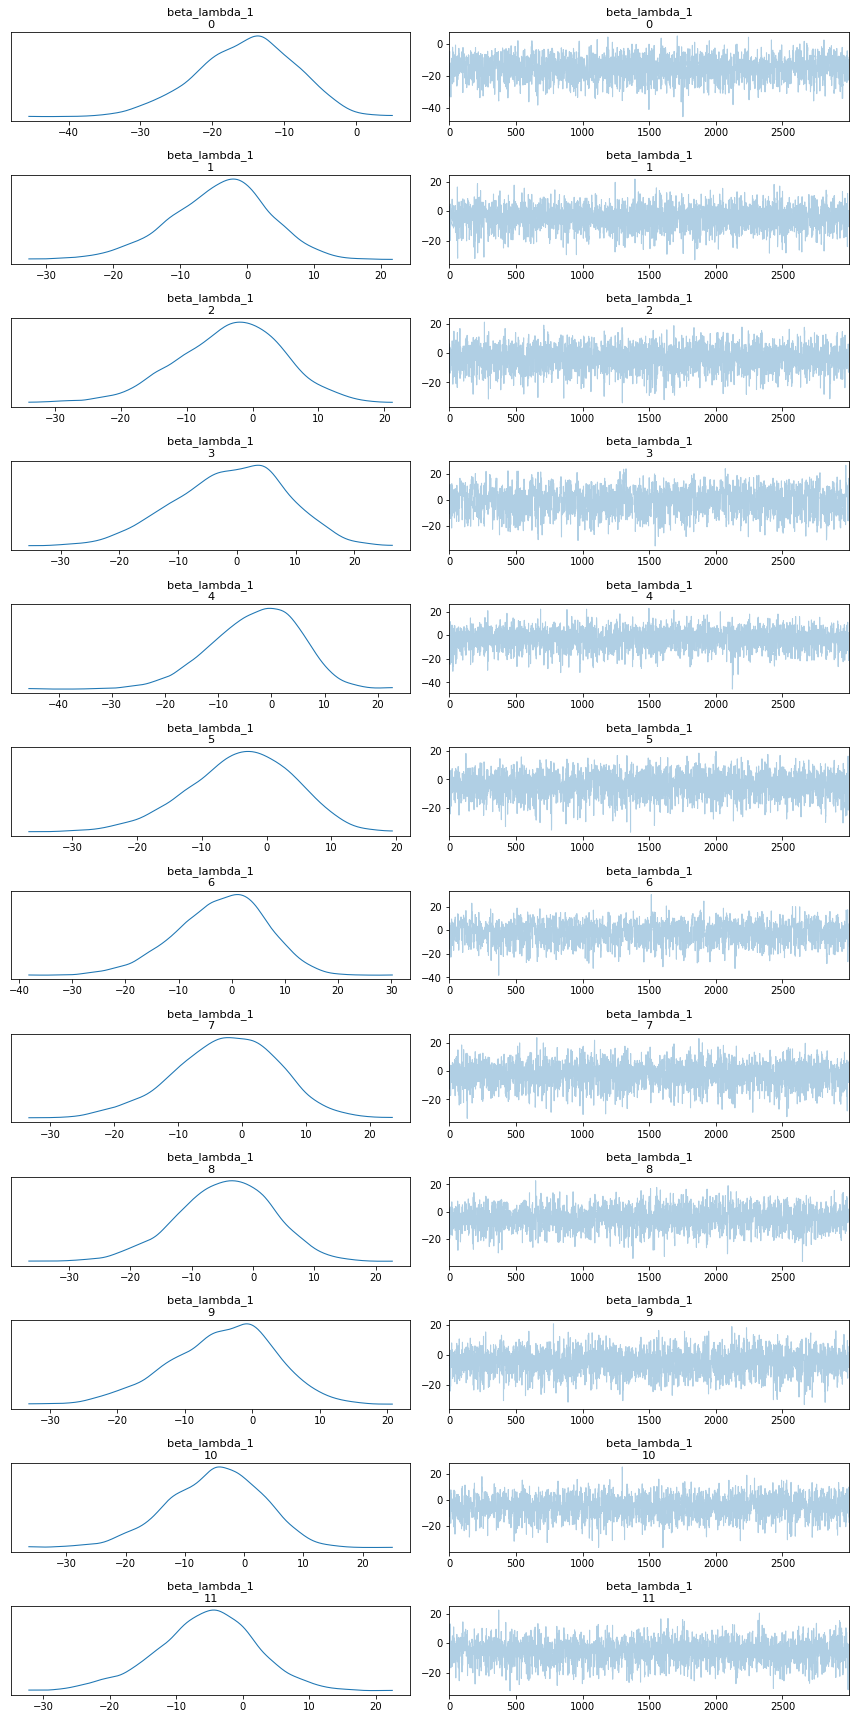

In [ ]:
az.plot_trace(cmdstanpy_data,var_names=["beta_lambda_1"], compact=False)
plt.tight_layout()
plt.show()

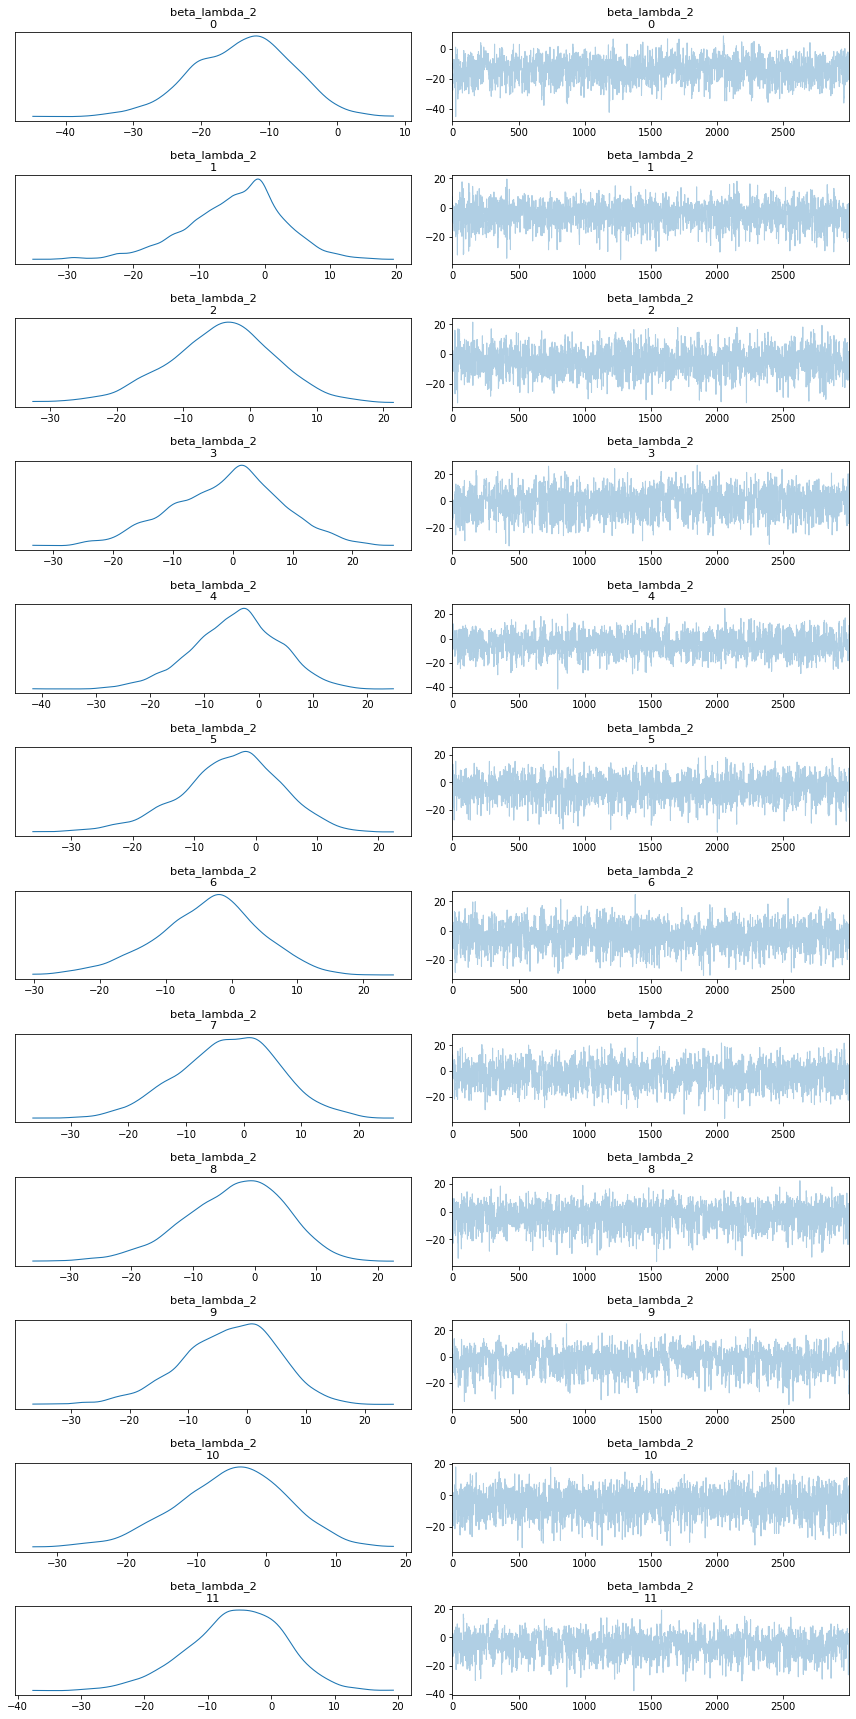

In [ ]:
az.plot_trace(cmdstanpy_data,var_names=["beta_lambda_2"], compact=False)
plt.tight_layout()
plt.show()

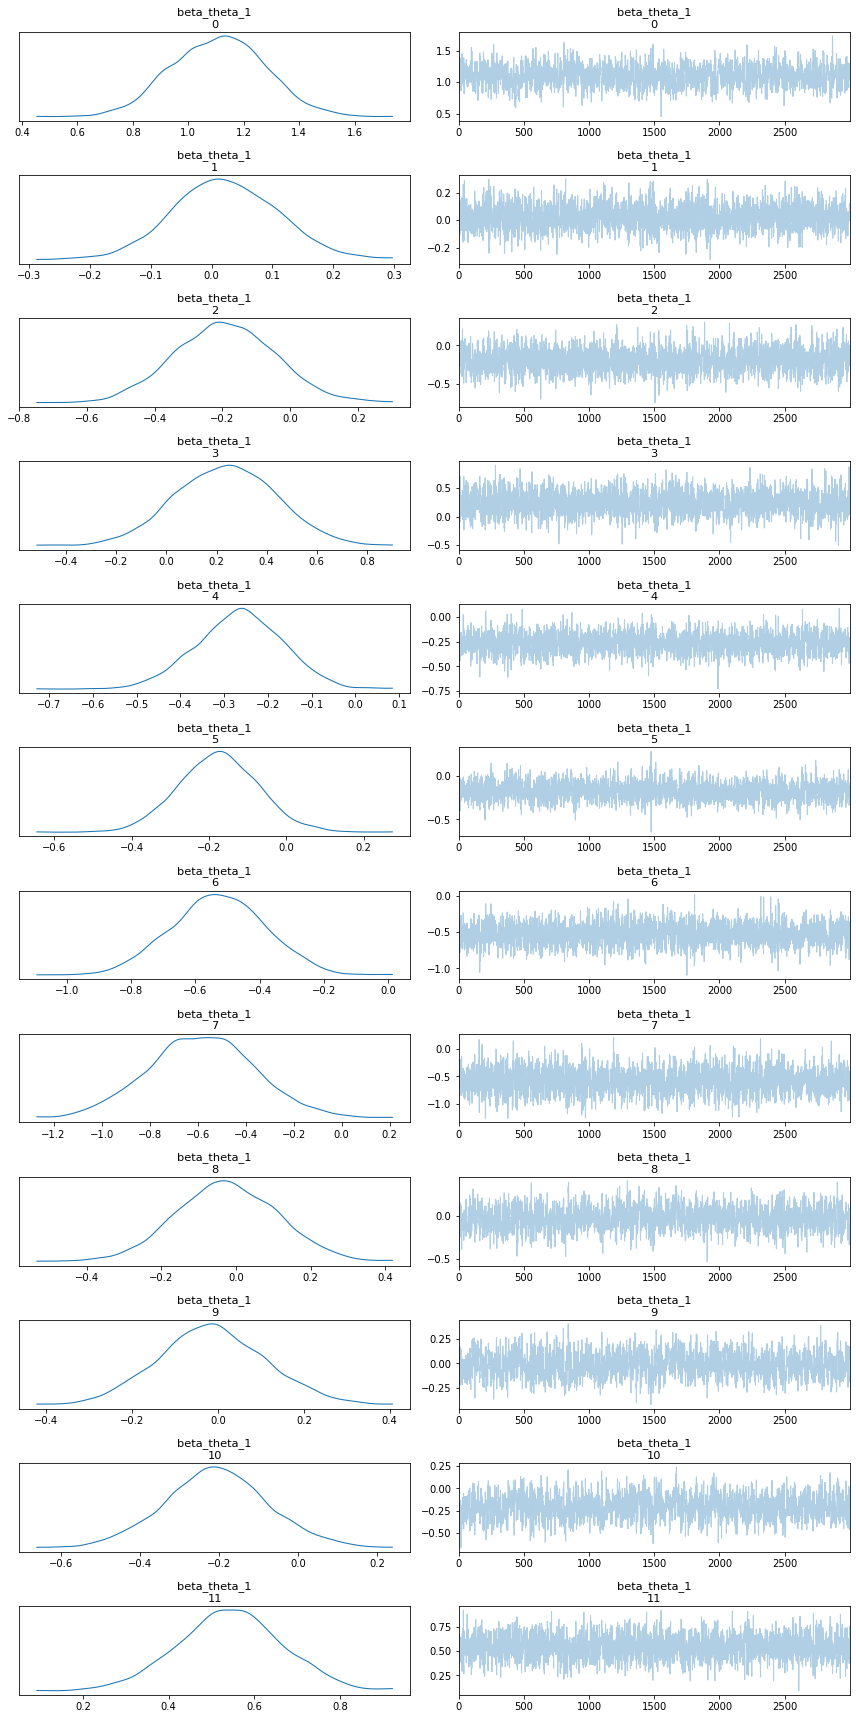

In [ ]:
az.plot_trace(cmdstanpy_data,var_names=["beta_theta_1"], compact=False)
plt.tight_layout()
plt.show()

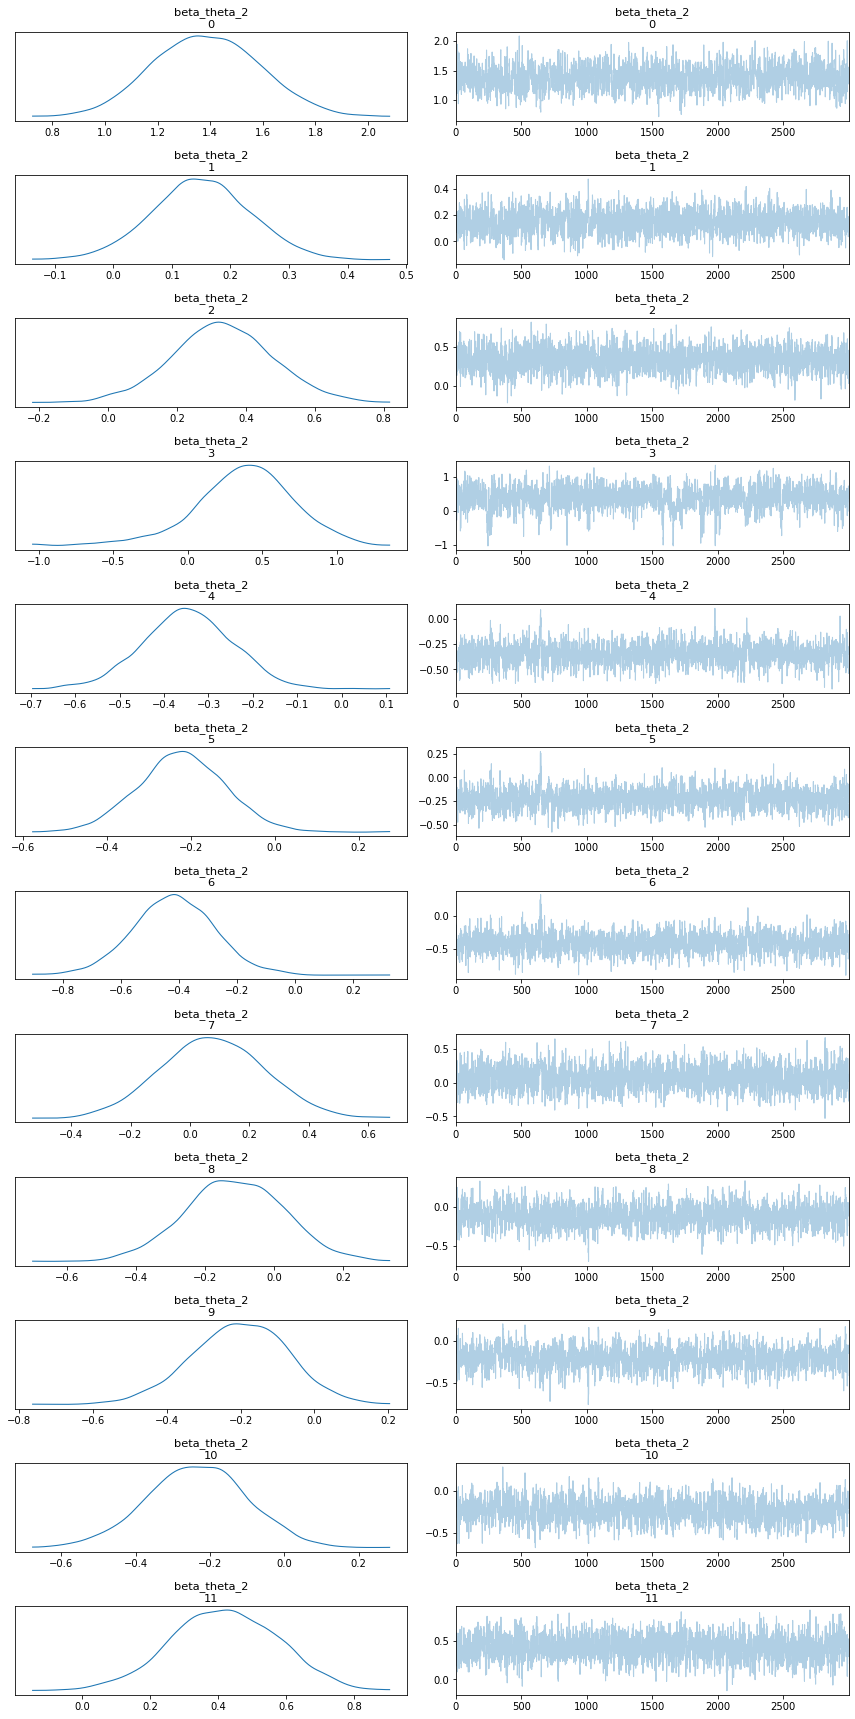

In [ ]:
az.plot_trace(cmdstanpy_data,var_names=["beta_theta_2"], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (84), generating only 20 plots
  warnings.warn(


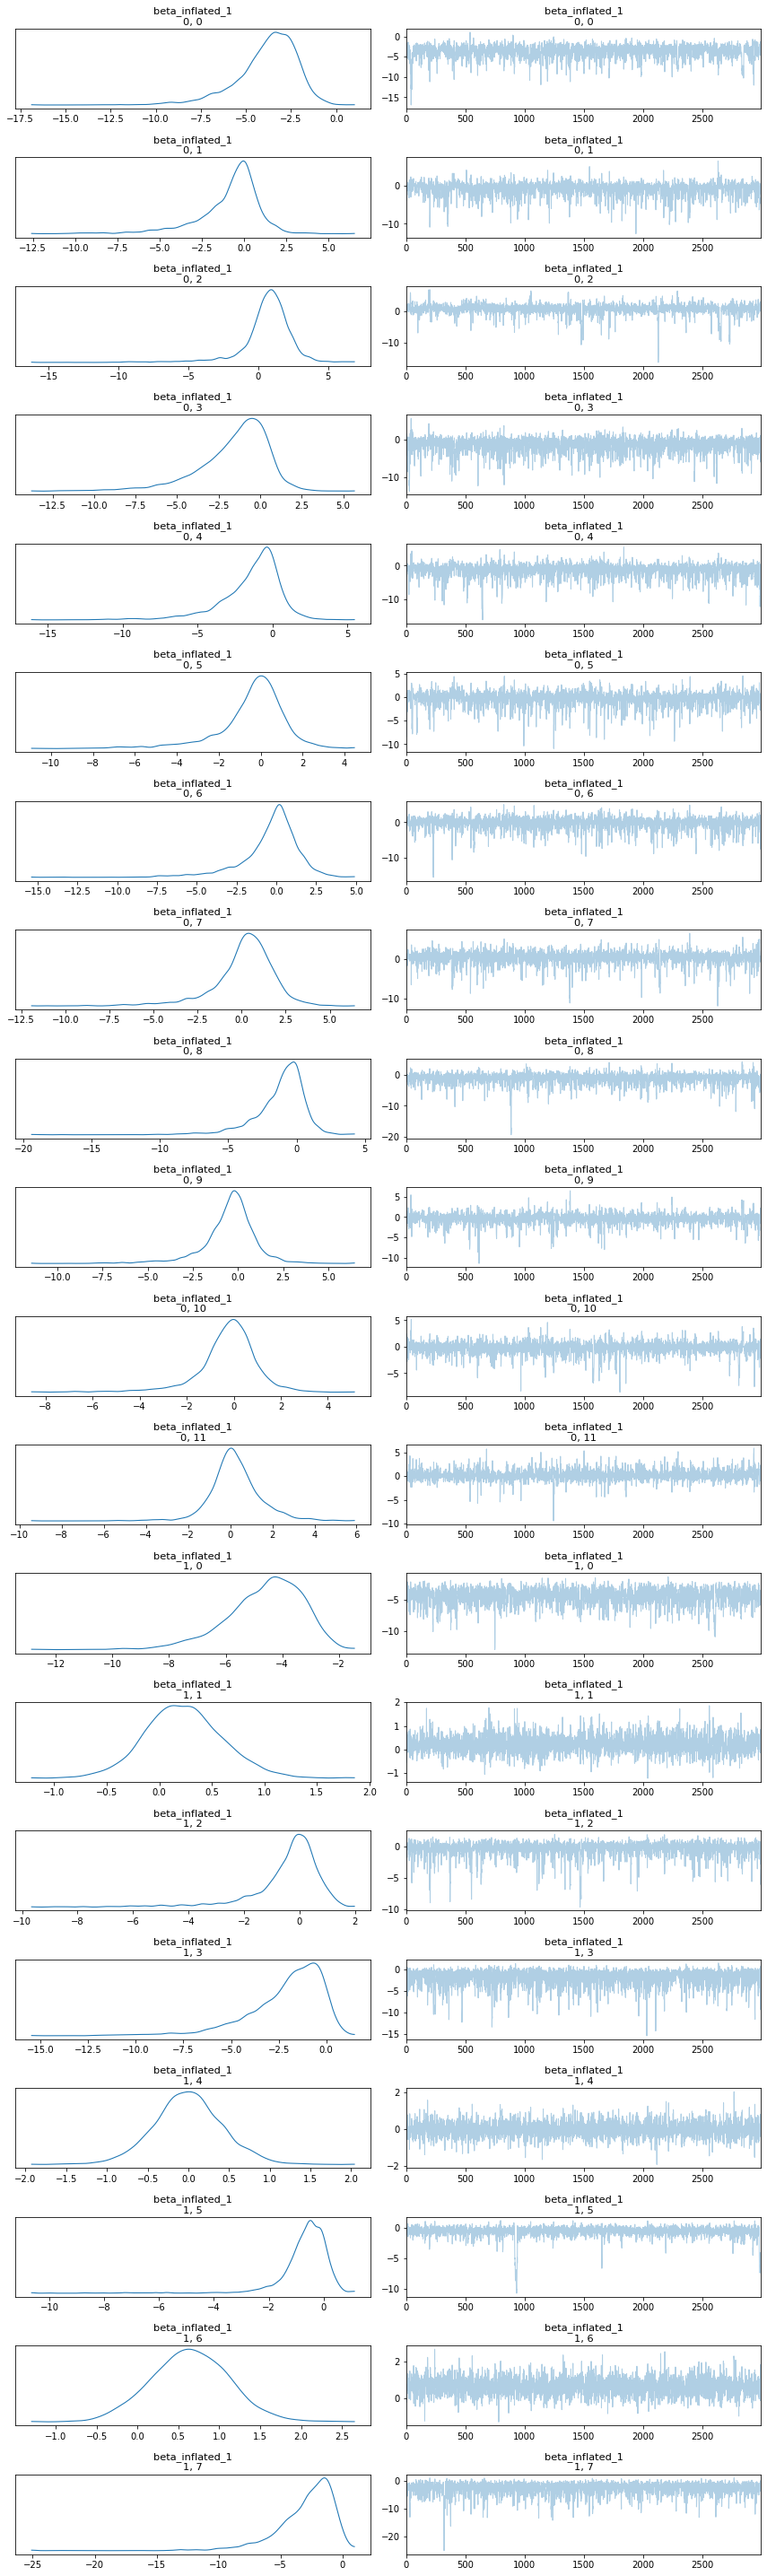

In [ ]:
az.plot_trace(cmdstanpy_data,var_names=["beta_inflated_1"], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/dist-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (84), generating only 20 plots
  warnings.warn(


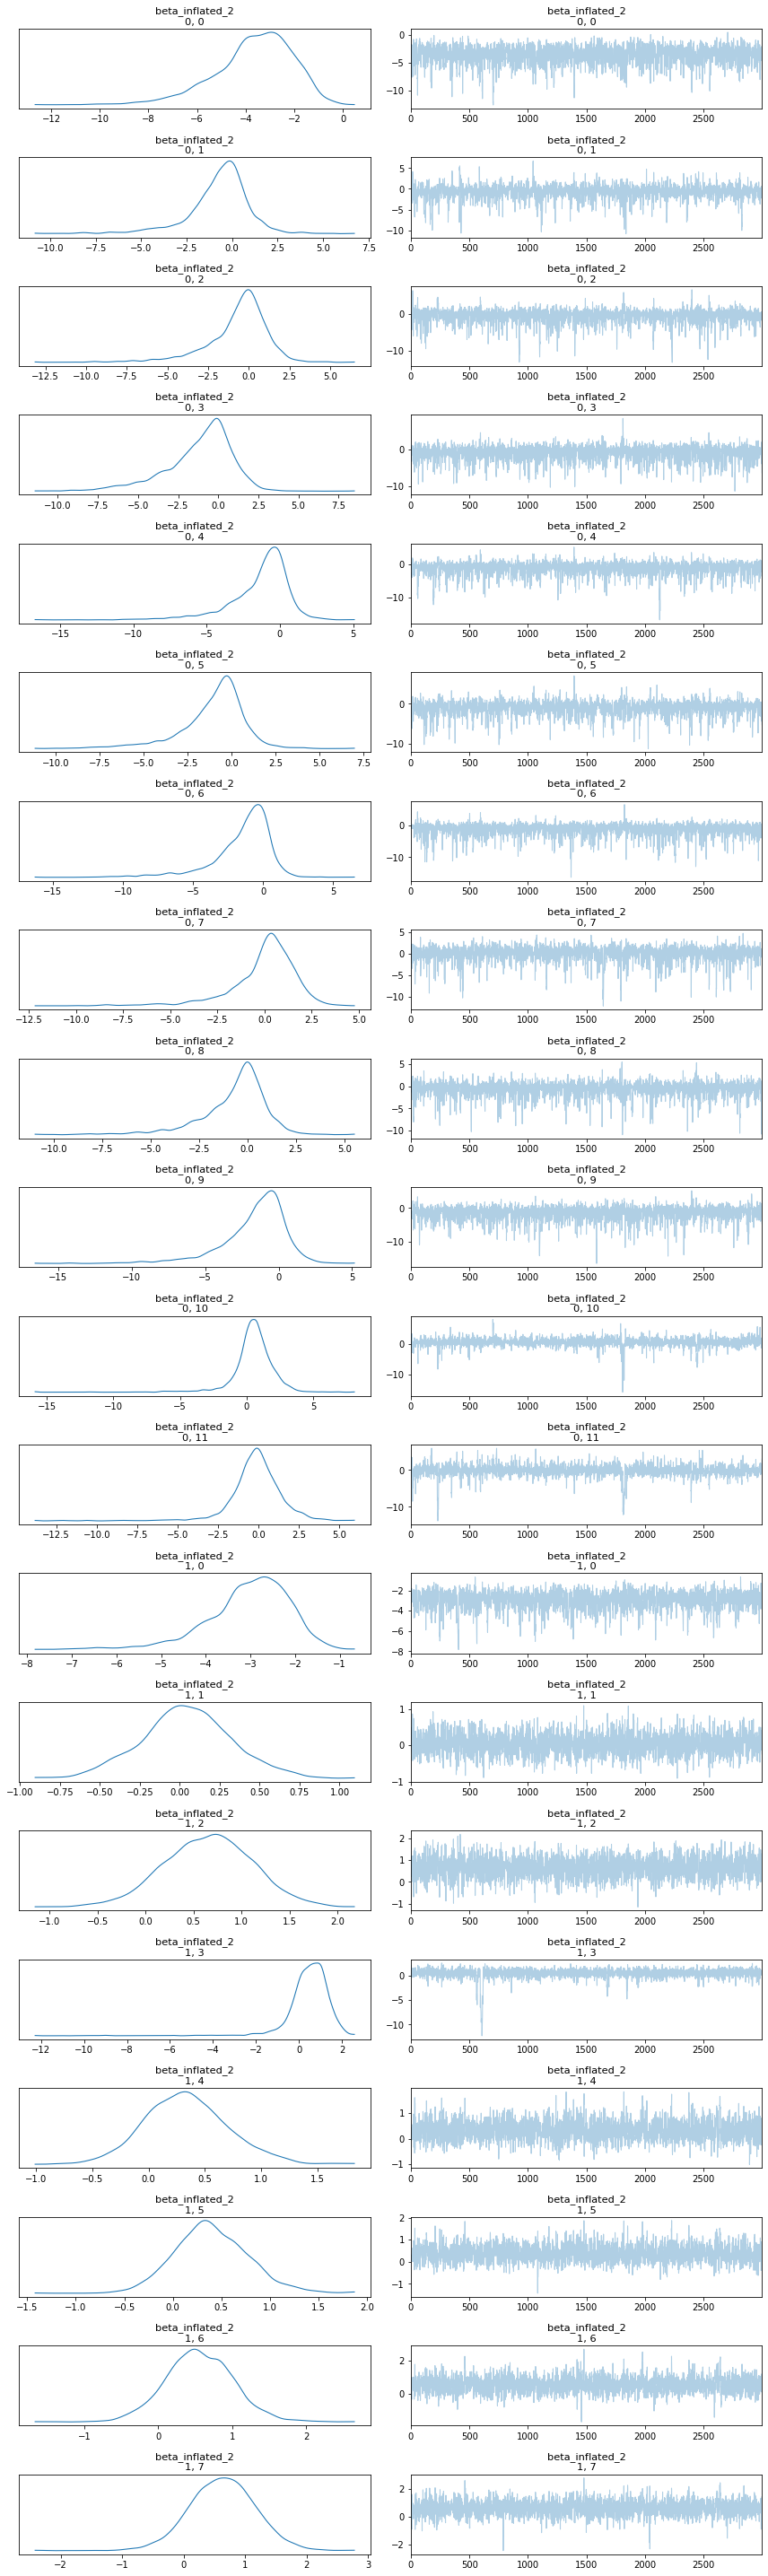

In [ ]:
az.plot_trace(cmdstanpy_data,var_names=["beta_inflated_2"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
az.to_netcdf(data = cmdstanpy_data, filename = '2y_12c_hier_f2.dat')

## Conclusions

In [ ]:
stacked = az.hdi(cmdstanpy_data, hdi_prob = 0.95)

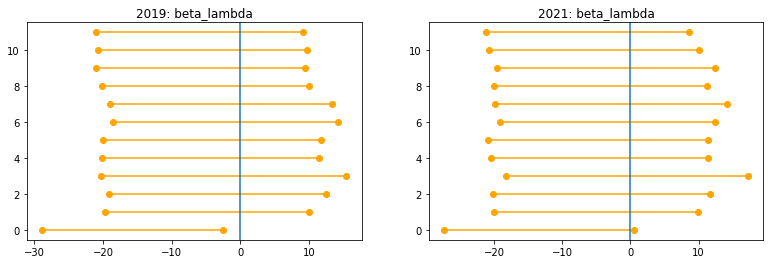

In [ ]:
# lambda
stacked_np_1 = stacked['beta_lambda_1'].to_numpy()
stacked_np_2 = stacked['beta_lambda_2'].to_numpy()
num_beta = range(stacked_np_1.shape[0])
fig, axes = plt.subplots(1 , 2, figsize=(13.2, 4))
for interval, y in zip(stacked_np_1,num_beta):
  axes[0].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
axes[0].axvline(0)
axes[0].set_title("2019: beta_lambda");
for interval, y in zip(stacked_np_2,num_beta):
  axes[1].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
axes[1].axvline(0)
axes[1].set_title("2021: beta_lambda");

As expected, no covariate is relevant for lambda in either years. There is however a difference regarding the intercept: in 2021 also beta_zero is irrelevant, while in 2019 it's relevant with negative values. In 2021 we therefore have a lambda of 2, while in 2019 of almost 1.

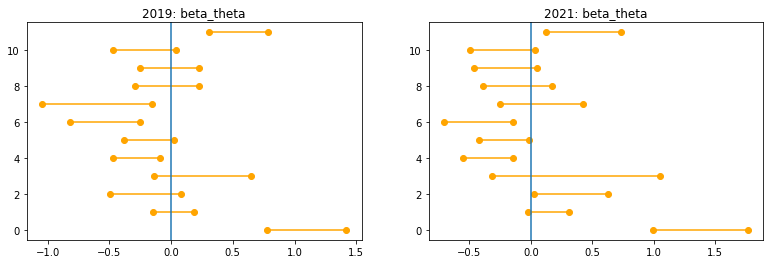

In [ ]:
# theta
stacked_np_1 = stacked['beta_theta_1'].to_numpy()
stacked_np_2 = stacked['beta_theta_2'].to_numpy()
num_beta = range(stacked_np_1.shape[0])
fig, axes = plt.subplots(1 , 2, figsize=(13.2, 4))
for interval, y in zip(stacked_np_1,num_beta):
  axes[0].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
axes[0].axvline(0)
axes[0].set_title("2019: beta_theta");
for interval, y in zip(stacked_np_2,num_beta):
  axes[1].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
axes[1].axvline(0)
axes[1].set_title("2021: beta_theta");

The relevant covariates shared by both years are north-east, south and vacation trip with more or less the same effect, positive for vacation trip and negative for north-east and south. As for the year-specific relevances, in 2019 living in the islands of the countries has a negative effect, while in 2021 divorce has a positive effect and center has a negative effect.

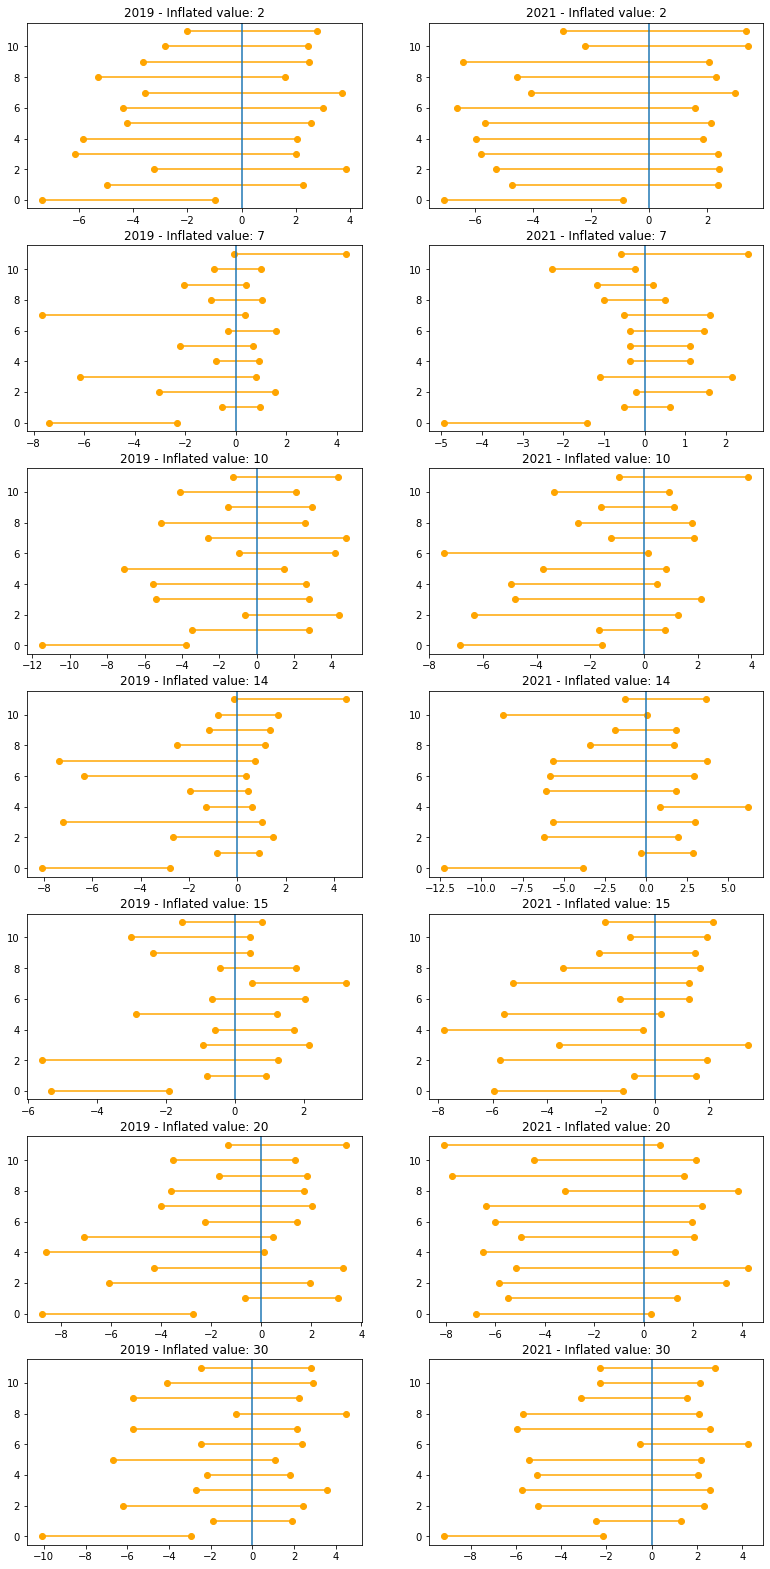

In [ ]:
# inflated values
stacked_np_1 = stacked['beta_inflated_1'].to_numpy()
stacked_np_2 = stacked['beta_inflated_2'].to_numpy()
fig, axes = plt.subplots(stacked_np_1.shape[0],2, figsize=(13.2, 28))
for i,j in enumerate(stacked_np_1):
  num_beta = range(j.shape[0])
  for interval, y in zip(j,num_beta):
    axes[i,0].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
  axes[i,0].axvline(0)
  axes[i,0].set_title("2019 - Inflated value: {}".format(inflated_values[i]))
for i,j in enumerate(stacked_np_2):
  num_beta = range(j.shape[0])
  for interval, y in zip(j,num_beta):
    axes[i,1].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
  axes[i,1].axvline(0)
  axes[i,1].set_title("2021 - Inflated value: {}".format(inflated_values[i]))

We can find relevant covariates for inflated values 7, 14 and 15, only (more or less) multiples of a week.

In 2021 we have that people who went to the university have a smaller probability of taking a full week of vacation.

In 2021 coming from the north-eastern part of the country is associated with a higher probability of taking trips of 14 days. 

Considering the inflated value 15, we have a positive effect in 2019 regarding the islands and a negative effect in 2021 regarding north-east.
